In [2]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install torch-summary
!pip install graphviz
!pip install torchview

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "ire"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached datasets-2.13.1-py3-none-any.whl (486 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-06-24 14:22:48--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7726 (7.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.54K  --.-KB/s    in 0s      

2023-06-24 14:22:49 (90.5 MB/s) - ‘utils.py’ saved [7726/7726]

--2023-06-24 14:22:49--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/plain]

In [7]:
import json
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [8]:
# set CUDA if available
"""if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")"""
device = torch.device('cpu') # otw goes out of memory

======= CUDA NOT Available, run on CPU =======


In [9]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_baseline',
    'tokenizer_name': 'bert-base-cased',
    'model_name': 'bert-base-cased',
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'epochs': 1,
    'seed': 42,
    'patience': 3,
    'early_stopping_threshold': 0
} # TODO: expand...

tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_config['model_name'],
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

############################ SUB-SAMPLE ############################
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]
####################################################################

train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

In [11]:
train_arguments = TrainingArguments(
    output_dir="./",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed']
) # TODO: custom other params

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))
trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
1,No log,0.715296,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=5, training_loss=0.747711181640625, metrics={'train_runtime': 114.1218, 'train_samples_per_second': 0.175, 'train_steps_per_second': 0.044, 'train_loss': 0.747711181640625, 'epoch': 1.0})

In [13]:
results = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
gold_emotions = label_encoder.decode(results.label_ids)
binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)
for i, bin_pred in enumerate(binarized_predictions):
  if np.all(bin_pred==0):
    binarized_predictions[i][np.argmax(results.predictions[i])] = 1
    # alternatively set the 'Neutral' emotion (cannot do it in compute_EMO_metrics_trainer)
    # binarized_predictions[i] = label_encoder.encode(['Neutral'])[0]
predicted_emotions = label_encoder.decode(binarized_predictions)
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['joy', 'surprise'] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.0,
 'micro_precision': 0.0,
 'micro_f': 0.0,
 'macro_recall': 0.0,
 'macro_precision': 0.0,
 'macro_F': 0.0,
 'accuracy': 0.0}

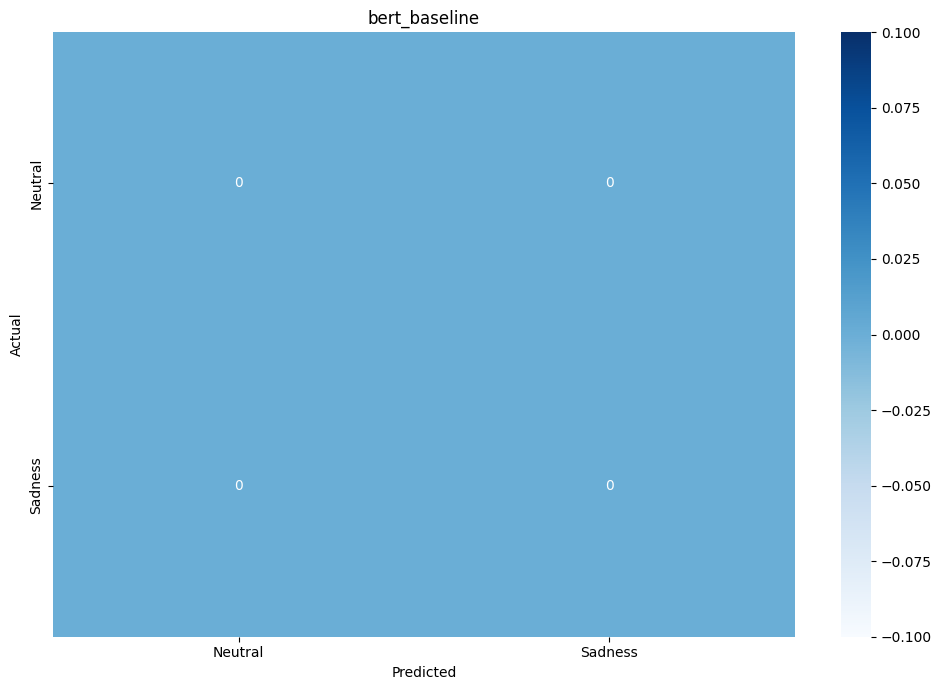

In [15]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [18]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [19]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


In [ ]:
# plot loss curve